<a href="https://colab.research.google.com/github/divijbuddareddy/Molecular-Potency-Prediction-A-GCN-and-Classical-ML-Approach-for-Drug-Analysis/blob/main/Molecular_Potency_Prediction_A_GCN_and_Classical_ML_Approach_for_Drug_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')

!pip install -q torch torch-geometric rdkit xgboost seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 56.7 MB/s eta 0:00:00


In [5]:
# ============================================================================
# COMPLETE GCN PROJECT FOR pIC50 PREDICTION - SINGLE FILE VERSION
# ============================================================================
# Copy this entire code into a single Google Colab cell
# First run: !pip install -q torch torch-geometric rdkit xgboost seaborn
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional, Dict
import warnings
warnings.filterwarnings('ignore')

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdFingerprintGenerator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

print("✓ All imports successful!")

# ============================================================================
# DATA PREPROCESSING
# ============================================================================

class MoleculeFeaturizer:
    """Convert SMILES to graph representations."""

    def __init__(self):
        self.atom_features_dim = 17

    def get_atom_features(self, atom) -> List[float]:
        """Extract atom-level features."""
        features = []
        atomic_num = atom.GetAtomicNum()
        common_atoms = [6, 7, 8, 9, 16, 17, 35]
        features.extend([1 if atomic_num == x else 0 for x in common_atoms])
        features.append(1 if atomic_num not in common_atoms else 0)
        features.append(atom.GetDegree())
        features.append(atom.GetFormalCharge())
        hybridization = atom.GetHybridization()
        hyb_types = [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3]
        features.extend([1 if hybridization == h else 0 for h in hyb_types])
        features.append(1 if atom.GetIsAromatic() else 0)
        features.append(atom.GetTotalNumHs())
        features.append(atom.GetMass())
        features.append(atom.GetNumRadicalElectrons())
        return features

    def smiles_to_graph(self, smiles: str) -> Optional[Data]:
        """Convert SMILES to PyTorch Geometric Data object."""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        atom_features = [self.get_atom_features(atom) for atom in mol.GetAtoms()]
        x = torch.tensor(atom_features, dtype=torch.float)
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices.append([i, j])
            edge_indices.append([j, i])
        if len(edge_indices) == 0:
            edge_index = torch.empty((2, 0), dtype=torch.long)
        else:
            edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        return Data(x=x, edge_index=edge_index)

class DatasetProcessor:
    """Process molecular dataset."""

    def __init__(self, csv_path: str, smiles_col: str = 'SMILES', target_col: str = 'pIC50'):
        self.df = pd.read_csv(csv_path)
        self.smiles_col = smiles_col
        self.target_col = target_col
        self.featurizer = MoleculeFeaturizer()
        print(f"✓ Loaded {len(self.df)} molecules")

    def process_dataset(self, test_size: float = 0.1, val_size: float = 0.1, random_state: int = 42):
        """Process and split dataset."""
        print(f"⚙️  Processing molecules...")
        graphs = []
        valid_smiles = []
        valid_targets = []
        for idx, row in self.df.iterrows():
            target_value = row[self.target_col]
            # Skip molecules with NaN or Inf target values
            if pd.isna(target_value) or np.isinf(target_value):
                continue

            graph = self.featurizer.smiles_to_graph(row[self.smiles_col])
            if graph is not None:
                graph.y = torch.tensor([target_value], dtype=torch.float)
                graphs.append(graph)
                valid_smiles.append(row[self.smiles_col])
                valid_targets.append(target_value)

        if not graphs:
            raise ValueError("No valid graphs could be generated from the dataset. Check SMILES strings and target values.")

        self.valid_df = pd.DataFrame({self.smiles_col: valid_smiles, self.target_col: valid_targets})
        train_val_graphs, test_graphs = train_test_split(graphs, test_size=test_size, random_state=random_state)
        val_size_adjusted = val_size / (1 - test_size)
        train_graphs, val_graphs = train_test_split(train_val_graphs, test_size=val_size_adjusted, random_state=random_state)
        print(f"✓ Train={len(train_graphs)}, Val={len(val_graphs)}, Test={len(test_graphs)}")
        return train_graphs, val_graphs, test_graphs

    def get_fingerprints(self, radius: int = 2, n_bits: int = 2048):
        """Generate ECFP4 fingerprints."""
        print("⚙️  Generating fingerprints...")
        fingerprints = []
        targets = []

        # Initialize the Morgan fingerprint generator once
        fgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)

        for idx, row in self.valid_df.iterrows():
            mol = Chem.MolFromSmiles(row[self.smiles_col])
            if mol is not None:
                # Use the generator to get the fingerprint as an ExplicitBitVect
                fp = fgen.GetFingerprint(mol)
                fingerprints.append(np.array(fp))
                targets.append(row[self.target_col])
        print(f"✓ Generated {len(fingerprints)} fingerprints")
        return np.array(fingerprints), np.array(targets)

# ============================================================================
# MODELS
# ============================================================================

class GCNModel(nn.Module):
    """Graph Convolutional Network."""

    def __init__(self, num_features: int, hidden_dim1: int = 64, hidden_dim2: int = 128, hidden_dim3: int = 256, dropout: float = 0.2):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.fc1 = nn.Linear(2 * hidden_dim3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class ImprovedGCNModel(nn.Module):
    """Improved GCN with attention pooling."""

    def __init__(self, num_features: int, hidden_dims: list = [64, 128, 256], dropout: float = 0.3):
        super(ImprovedGCNModel, self).__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(GCNConv(num_features, hidden_dims[0]))
        self.bns.append(nn.BatchNorm1d(hidden_dims[0]))
        for i in range(len(hidden_dims) - 1):
            self.convs.append(GCNConv(hidden_dims[i], hidden_dims[i+1]))
            self.bns.append(nn.BatchNorm1d(hidden_dims[i+1]))
        self.att_layer = nn.Linear(hidden_dims[-1], 1)
        self.fc1 = nn.Linear(hidden_dims[-1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)
        att_weights = torch.sigmoid(self.att_layer(x))
        x_weighted = x * att_weights
        x = global_mean_pool(x_weighted, batch)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class GATModel(nn.Module):
    """Graph Attention Network."""

    def __init__(self, num_features: int, hidden_dim: int = 64, num_heads: int = 4, dropout: float = 0.2):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, dropout=dropout)
        self.conv3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ============================================================================
# EVALUATION & VISUALIZATION
# ============================================================================

def evaluate_model(y_true, y_pred):
    """Calculate metrics."""
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

def print_metrics(metrics, model_name="Model"):
    """Print metrics."""
    print(f"\n{model_name} Performance:")
    print("=" * 50)
    print(f"R² Score:  {metrics['R2']:.4f}")
    print(f"RMSE:      {metrics['RMSE']:.4f}")
    print(f"MAE:       {metrics['MAE']:.4f}")
    print(f"MSE:       {metrics['MSE']:.4f}")
    print("=" * 50)

def predict_gcn(model, data_loader, device):
    """Generate predictions."""
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            output = model(data)
            predictions.extend(output.cpu().numpy())
            targets.extend(data.y.cpu().numpy())
    return np.array(predictions).flatten(), np.array(targets).flatten()

def plot_predictions(y_true, y_pred, title="Predicted vs Actual pIC50"):
    """Plot predictions."""
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual pIC50', fontsize=14)
    plt.ylabel('Predicted pIC50', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout()
    plt.show()

def plot_training_history(train_losses, val_losses):
    """Plot training history."""
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss (MSE)', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_model_comparison(results, metric='R2'):
    """Compare models."""
    models = list(results.keys())
    values = [results[model][metric] for model in models]
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("husl", len(models))
    bars = plt.bar(models, values, color=colors, edgecolor='black', linewidth=1.5)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.xlabel('Model', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.title(f'Model Comparison - {metric}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title="Residual Plot"):
    """Plot residuals."""
    residuals = y_true - y_pred
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.scatter(y_pred, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
    ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax1.set_xlabel('Predicted pIC50', fontsize=12)
    ax1.set_ylabel('Residuals', fontsize=12)
    ax1.set_title('Residuals vs Predicted', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Residuals', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Residuals', fontsize=14)
    ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax2.grid(True, alpha=0.3)
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# ============================================================================
# TRAINING
# ============================================================================

def train_gcn(model, train_loader, val_loader, device, epochs=150, lr=0.001, patience=50):
    """Train GCN with early stopping."""
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    print(f"\n🚀 Training {model.__class__.__name__}...")
    print("=" * 70)
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.num_graphs
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data.y)
                val_loss += loss.item() * data.num_graphs
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Best: {best_val_loss:.4f}")
        if patience_counter >= patience:
            print(f"\n⏸️  Early stopping at epoch {epoch}")
            break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print("=" * 70)
    print("✓ Training completed!\n")
    return model, train_losses, val_losses

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def run_complete_pipeline(csv_path, smiles_col='SMILES', target_col='pIC50', model_type='gcn', batch_size=64, epochs=150, compare_baselines=True):
    """Run complete pipeline."""
    print("\n" + "=" * 70)
    print("🧪 GCN PIPELINE FOR pIC50 PREDICTION")
    print("=" * 70)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n💻 Using device: {device}")

    # Data processing
    print("\n" + "=" * 70)
    print("📊 STEP 1: DATA PROCESSING")
    print("=" * 70)
    processor = DatasetProcessor(csv_path, smiles_col, target_col)
    train_graphs, val_graphs, test_graphs = processor.process_dataset()

    # The previous check for NaN values was informative but not corrective.
    # With the modification to DatasetProcessor, graphs with NaN targets are now filtered out.
    # The following checks are no longer strictly necessary for error prevention,
    # but can remain for debugging purposes if needed.
    # for graph_list, name in [(train_graphs, 'Train'), (val_graphs, 'Validation'), (test_graphs, 'Test')]:
    #     for i, graph in enumerate(graph_list):
    #         if torch.isnan(graph.x).any() or torch.isinf(graph.x).any():
    #             print(f"⚠️  Warning: {name} graph {i} contains NaN/Inf in node features (x).")
    #         if torch.isnan(graph.y).any() or torch.isinf(graph.y).any():
    #             print(f"⚠️  Warning: {name} graph {i} contains NaN/Inf in target (y).")


    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

    # Model training
    print("\n" + "=" * 70)
    print("🤖 STEP 2: MODEL TRAINING")
    print("=" * 70)
    num_features = train_graphs[0].num_node_features
    print(f"\n📐 Node features: {num_features}")
    if model_type == 'gcn':
        model = GCNModel(num_features=num_features)
    elif model_type == 'improved_gcn':
        model = ImprovedGCNModel(num_features=num_features)
    elif model_type == 'gat':
        model = GATModel(num_features=num_features)
    else:
        raise ValueError(f"Unknown model: {model_type}")
    print(f"✓ Initialized {model.__class__.__name__}")
    model, train_losses, val_losses = train_gcn(model, train_loader, val_loader, device, epochs=epochs, lr=0.001) # Reduced learning rate

    # Evaluation
    print("\n" + "=" * 70)
    print("📈 STEP 3: EVALUATION")
    print("=" * 70)
    y_pred, y_true = predict_gcn(model, test_loader, device)
    gcn_metrics = evaluate_model(y_true, y_pred)
    print_metrics(gcn_metrics, model_name=f"{model_type.upper()}")
    all_results = {f"{model_type.upper()}": gcn_metrics}

    # Visualization
    print("\n" + "=" * 70)
    print("📊 STEP 4: VISUALIZATION")
    print("=" * 70)
    print("\n🎨 Generating plots...")
    plot_predictions(y_true, y_pred, title=f"{model_type.upper()} - Test Set")
    plot_training_history(train_losses, val_losses)
    plot_residuals(y_true, y_pred, title=f"{model_type.upper()} - Residuals")

    # Baseline comparison
    if compare_baselines:
        print("\n" + "=" * 70)
        print("🔬 STEP 5: BASELINE COMPARISON")
        print("=" * 70)
        fingerprints, targets = processor.get_fingerprints()
        X_train_val, X_test, y_train_val, y_test = train_test_split(fingerprints, targets, test_size=0.1, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42)

        print("\n🌲 Training Random Forest...")
        rf_model = RandomForestRegressor(n_estimators=200, max_depth=30, min_samples_split=5, random_state=42, n_jobs=-1)
        rf_model.fit(X_train, y_train)
        y_pred_rf = rf_model.predict(X_test)
        rf_metrics = evaluate_model(y_test, y_pred_rf)
        print_metrics(rf_metrics, model_name="Random Forest")
        all_results['Random Forest'] = rf_metrics
        plot_predictions(y_test, y_pred_rf, title="Random Forest - Test Set")

        print("\n⚡ Training XGBoost...")
        xgb_model = XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1)
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        xgb_metrics = evaluate_model(y_test, y_pred_xgb)
        print_metrics(xgb_metrics, model_name="XGBoost")
        all_results['XGBoost'] = xgb_metrics
        plot_predictions(y_test, y_pred_xgb, title="XGBoost - Test Set")

        print("\n📊 Generating comparison plots...")
        plot_model_comparison(all_results, metric='R2')
        plot_model_comparison(all_results, metric='RMSE')
        plot_model_comparison(all_results, metric='MAE')

    # Summary
    print("\n" + "=" * 70)
    print("📝 FINAL SUMMARY")
    print("=" * 70)
    print("\n🏆 Performance Comparison:")
    print("-" * 70)
    print(f"{'Model':<20s} | {'R²':>6s} | {'RMSE':>6s} | {'MAE':>6s}")
    print("-" * 70)
    for model_name, metrics in all_results.items():
        print(f"{model_name:<20s} | {metrics['R2']:>6.4f} | {metrics['RMSE']:>6.4f} | {metrics['MAE']:>6.4f}")
    print("-" * 70)
    best_model = max(all_results.items(), key=lambda x: x[1]['R2'])
    print(f"\n🥇 Best: {best_model[0]} (R² = {best_model[1]['R2']:.4f})")
    print("\n" + "=" * 70)
    print("✅ PIPELINE COMPLETED!")
    print("=" * 70)
    return all_results

# ============================================================================
# USAGE
# ============================================================================

print("\n" + "=" * 70)
print("✅ CODE LOADED!")
print("=" * 70)
print("\n📖 USAGE:")
print("1. Upload CSV: from google.colab import files; uploaded = files.upload(); csv_path = list(uploaded.keys())[0]")
print("2. Run: results = run_complete_pipeline(csv_path=csv_path, model_type='gcn', epochs=100)")
print("3. Try: help(run_complete_pipeline)")
print("=" * 70)


✓ All imports successful!

✅ CODE LOADED!

📖 USAGE:
1. Upload CSV: from google.colab import files; uploaded = files.upload(); csv_path = list(uploaded.keys())[0]
2. Run: results = run_complete_pipeline(csv_path=csv_path, model_type='gcn', epochs=100)
3. Try: help(run_complete_pipeline)


In [6]:
from google.colab import files
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]

Saving smilesdataset.csv to smilesdataset.csv


In [7]:
import pandas as pd
df = pd.read_csv(csv_path)
print(df.head())
print(df.columns)

                                              SMILES  pIC50  \
0         O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1   4.26   
1  O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...   4.34   
2             NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO   4.53   
3                NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21   4.56   
4                  CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1   4.59   

                                                mol  num_atoms    logP  
0  <rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>         25  4.1591  
1  <rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>         36  3.6743  
2  <rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>         23  1.5361  
3  <rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>         22  0.9510  
4  <rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>         21  3.2130  
Index(['SMILES', 'pIC50', 'mol', 'num_atoms', 'logP'], dtype='object')



🧪 GCN PIPELINE FOR pIC50 PREDICTION

💻 Using device: cuda

📊 STEP 1: DATA PROCESSING
✓ Loaded 16087 molecules
⚙️  Processing molecules...
✓ Train=12029, Val=1504, Test=1504

🤖 STEP 2: MODEL TRAINING

📐 Node features: 17
✓ Initialized GCNModel

🚀 Training GCNModel...
Epoch 010/100 | Train Loss: 6.2402 | Val Loss: 6.0066 | Best: 5.9925
Epoch 020/100 | Train Loss: 6.2218 | Val Loss: 6.0139 | Best: 5.9925
Epoch 030/100 | Train Loss: 6.2182 | Val Loss: 6.0161 | Best: 5.9925
Epoch 040/100 | Train Loss: 6.2175 | Val Loss: 6.0245 | Best: 5.9925
Epoch 050/100 | Train Loss: 6.2130 | Val Loss: 6.0112 | Best: 5.9925

⏸️  Early stopping at epoch 57
✓ Training completed!


📈 STEP 3: EVALUATION

GCN Performance:
R² Score:  -0.0018
RMSE:      2.3994
MAE:       1.4881
MSE:       5.7571

📊 STEP 4: VISUALIZATION

🎨 Generating plots...


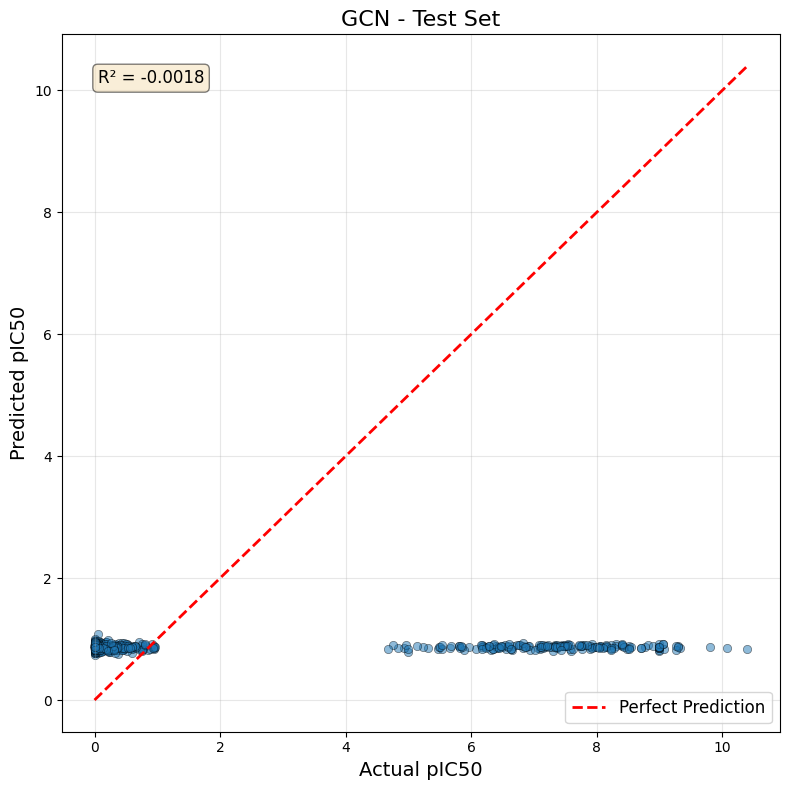

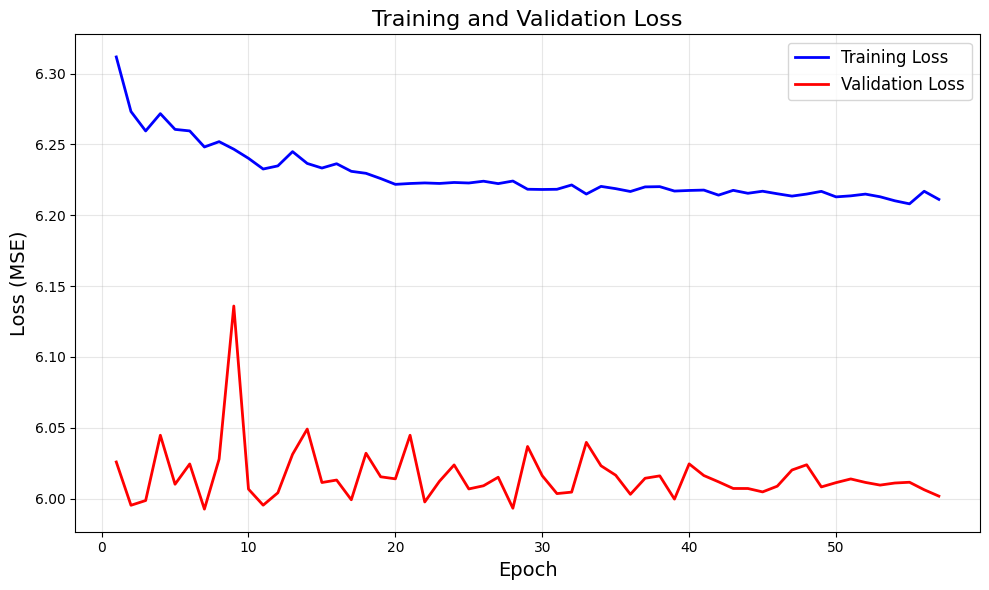

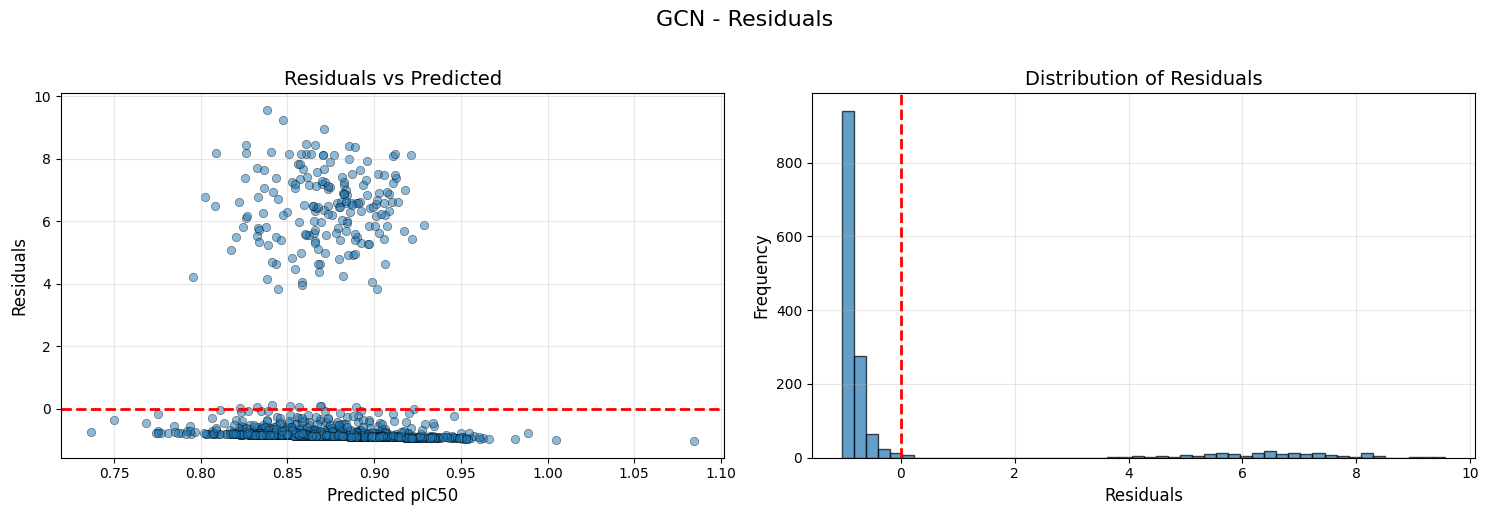


🔬 STEP 5: BASELINE COMPARISON
⚙️  Generating fingerprints...
✓ Generated 15037 fingerprints

🌲 Training Random Forest...

Random Forest Performance:
R² Score:  0.9520
RMSE:      0.5252
MAE:       0.1801
MSE:       0.2758


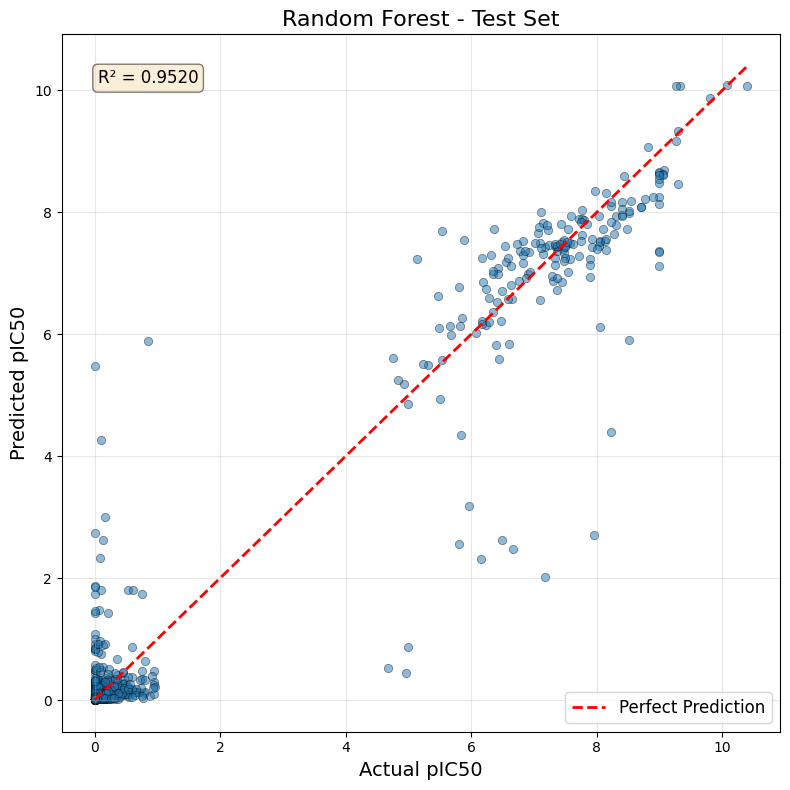


⚡ Training XGBoost...

XGBoost Performance:
R² Score:  0.9567
RMSE:      0.4991
MAE:       0.1662
MSE:       0.2491


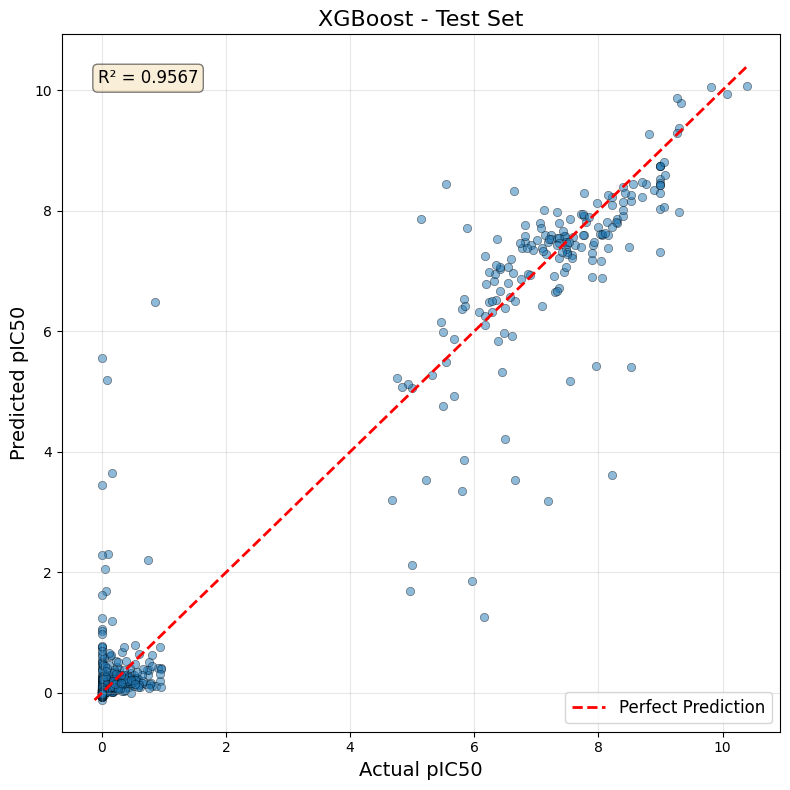


📊 Generating comparison plots...


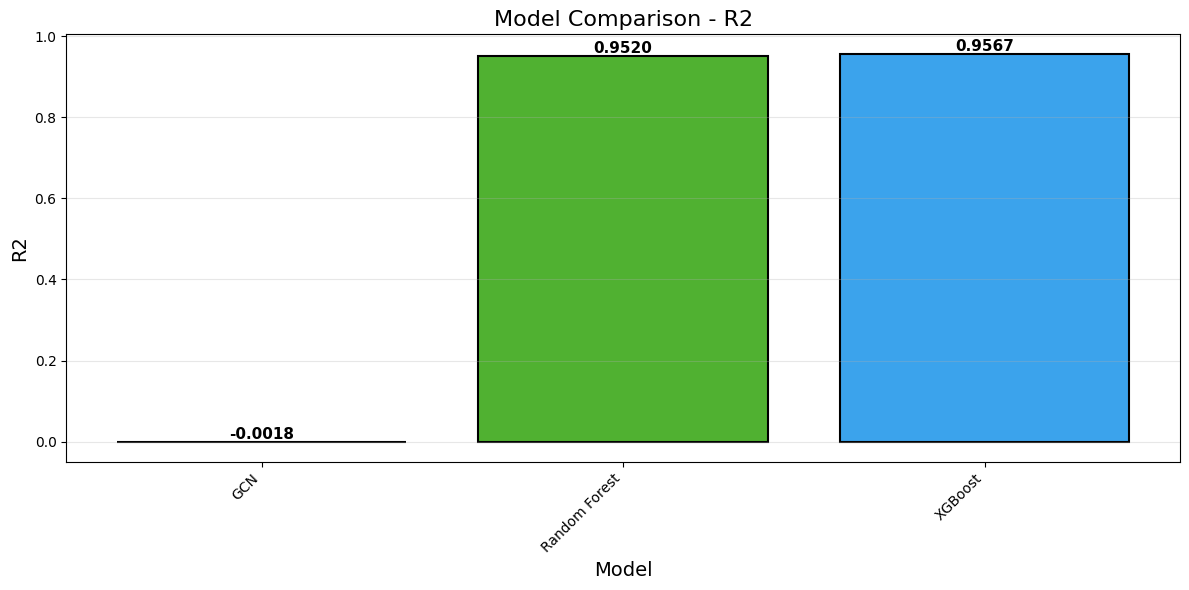

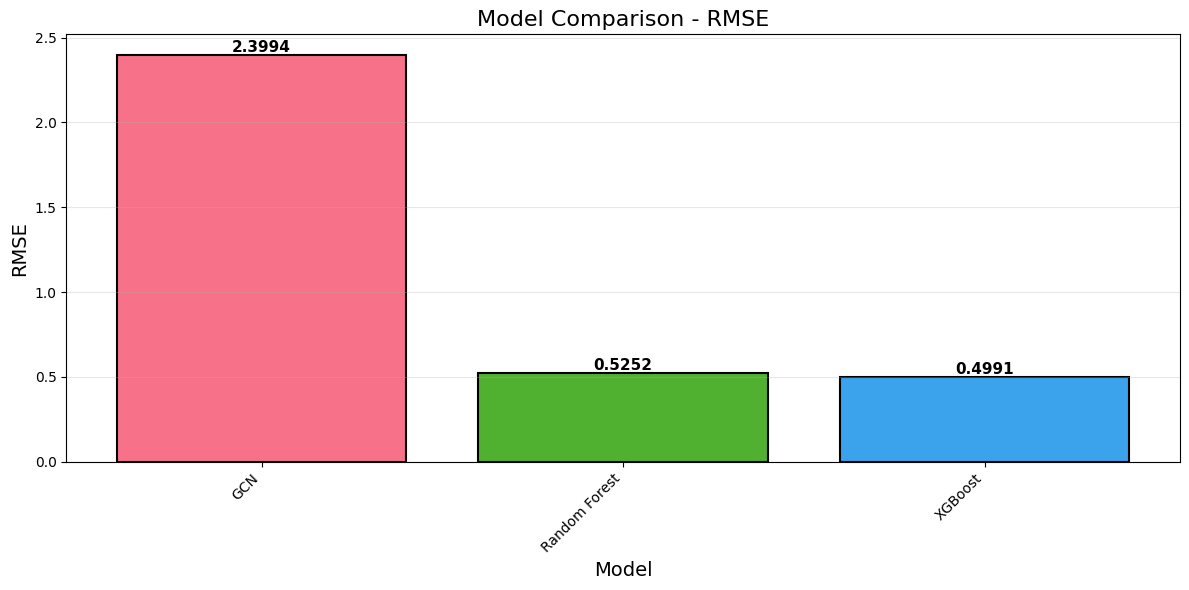

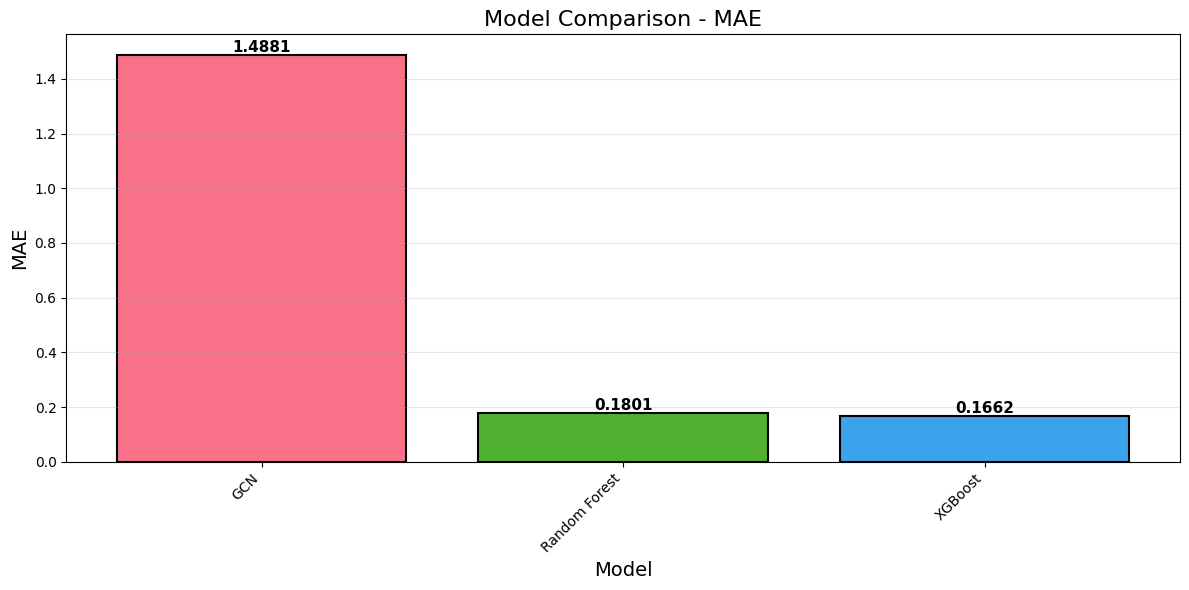


📝 FINAL SUMMARY

🏆 Performance Comparison:
----------------------------------------------------------------------
Model                |     R² |   RMSE |    MAE
----------------------------------------------------------------------
GCN                  | -0.0018 | 2.3994 | 1.4881
Random Forest        | 0.9520 | 0.5252 | 0.1801
XGBoost              | 0.9567 | 0.4991 | 0.1662
----------------------------------------------------------------------

🥇 Best: XGBoost (R² = 0.9567)

✅ PIPELINE COMPLETED!


In [8]:
results = run_complete_pipeline(
    csv_path=csv_path,
    smiles_col='SMILES',  # Adjust if different
    target_col='pIC50',    # Adjust if different
    model_type='gcn',
    epochs=100
)

In [ ]:
print(results)

{'GCN': {'MSE': 5.734541416168213, 'RMSE': np.float64(2.394690254744486), 'MAE': 1.4596655368804932, 'R2': 0.00208437442779541}, 'XGBoost': {'MSE': 0.24910063689026923, 'RMSE': np.float64(0.4990998265780797), 'MAE': 0.1661608769535352, 'R2': 0.9566519094793108}}


**Reasoning**:
The subtask requires creating a Python list named `new_smiles` with example SMILES strings. This code block will initialize the list with a few distinct SMILES strings.



In [12]:
new_smiles = [
    'CCO',
    'C1CCCCC1',
    'CC(=O)Oc1ccccc1C(=O)O',
    'CC(C)(C)NCC(O)c1ccc(O)c(CO)c1',
    'O=C(O)c1ccccc1C(=O)NCCS'
]

print(f"Created a list of {len(new_smiles)} new SMILES strings for prediction.")
print(new_smiles)

Created a list of 5 new SMILES strings for prediction.
['CCO', 'C1CCCCC1', 'CC(=O)Oc1ccccc1C(=O)O', 'CC(C)(C)NCC(O)c1ccc(O)c(CO)c1', 'O=C(O)c1ccccc1C(=O)NCCS']


In [16]:
print("\n" + "=" * 70)
print("📈 Re-training XGBoost for new predictions...")
print("=" * 70)

# Re-initialize processor to get the same valid_df for fingerprint generation
processor = DatasetProcessor(csv_path, smiles_col='SMILES', target_col='pIC50')

# Call process_dataset to populate valid_df before calling get_fingerprints
# The return values (train_graphs, etc.) are not needed here, but the side effect of populating valid_df is.
_, _, _ = processor.process_dataset()

# Generate fingerprints from the full processed dataset (as done internally for baselines)
all_fingerprints, all_targets = processor.get_fingerprints()

# Re-split the data for XGBoost training using the same parameters as in run_complete_pipeline
# The train_test_split is performed on the *full* fingerprint dataset, not the graph splits.
# test_size=0.1, val_size_adjusted for split from train_val_graphs was 0.1 / (1-0.1) = 0.111
# So, the effective split for test_size in the first split was 0.1, and for val_size in the second split was 0.111.
# To get the final train, val, test splits for fingerprints, we mimic the run_complete_pipeline logic:
# 1. Split into (train+val) and test
# 2. Split (train+val) into train and val
X_train_val_fp, X_test_fp, y_train_val_fp, y_test_fp = train_test_split(all_fingerprints, all_targets, test_size=0.1, random_state=42)
X_train_fp, X_val_fp, y_train_fp, y_val_fp = train_test_split(X_train_val_fp, y_train_val_fp, test_size=(0.1 / (1 - 0.1)), random_state=42)

# Train the XGBoost model using the same hyperparameters
xgb_model_for_prediction = XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model_for_prediction.fit(X_train_fp, y_train_fp)

print("✓ XGBoost model re-trained successfully!")

def predict_new_smiles_with_xgboost(smiles_list: List[str], model: XGBRegressor, radius: int = 2, n_bits: int = 2048):
    """Predict pIC50 for new SMILES strings using a trained XGBoost model."""
    print(f"\n⚙️  Generating fingerprints for {len(smiles_list)} new SMILES...")
    new_fingerprints = []
    fgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    valid_smiles_for_pred = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = fgen.GetFingerprint(mol)
            new_fingerprints.append(np.array(fp))
            valid_smiles_for_pred.append(smiles)
        else:
            print(f"⚠️  Warning: Could not process SMILES '{smiles}', skipping.")

    if not new_fingerprints:
        print("No valid SMILES provided for prediction.")
        return None, None

    new_fingerprints_array = np.array(new_fingerprints)
    print(f"✓ Generated {len(new_fingerprints_array)} fingerprints.")
    print("\n⚡ Making predictions...")
    predictions = model.predict(new_fingerprints_array)
    return valid_smiles_for_pred, predictions

# Make predictions for the new_smiles list
predicted_smiles, predicted_pic50s = predict_new_smiles_with_xgboost(new_smiles, xgb_model_for_prediction)

print("\n" + "=" * 70)
print("RESULTS: New SMILES pIC50 Predictions (using XGBoost)")
print("=" * 70)
if predicted_smiles:
    for smiles, pic50 in zip(predicted_smiles, predicted_pic50s):
        print(f"SMILES: {smiles:<30s} | Predicted pIC50: {pic50:.4f}")
else:
    print("No predictions could be made.")
print("=" * 70)


📈 Re-training XGBoost for new predictions...
✓ Loaded 16087 molecules
⚙️  Processing molecules...
✓ Train=12029, Val=1504, Test=1504
⚙️  Generating fingerprints...
✓ Generated 15037 fingerprints
✓ XGBoost model re-trained successfully!

⚙️  Generating fingerprints for 5 new SMILES...
✓ Generated 5 fingerprints.

⚡ Making predictions...

RESULTS: New SMILES pIC50 Predictions (using XGBoost)
SMILES: CCO                            | Predicted pIC50: 0.1652
SMILES: C1CCCCC1                       | Predicted pIC50: 0.1181
SMILES: CC(=O)Oc1ccccc1C(=O)O          | Predicted pIC50: 0.0380
SMILES: CC(C)(C)NCC(O)c1ccc(O)c(CO)c1  | Predicted pIC50: 0.1154
SMILES: O=C(O)c1ccccc1C(=O)NCCS        | Predicted pIC50: 0.0680
